In [7]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import pickle
from PIL import Image
from glob import glob
%matplotlib inline

In [2]:
age = glob('age/*.jpg')

In [3]:
def getSize(file):
    # go through every image and return the size 
    img = Image.open(file)
    return img.size[0]

In [4]:
df = pd.DataFrame(data=age, columns=['path'])

In [5]:
df['size'] = df['path'].apply(getSize)

In [6]:
df.describe()

,size
count,9780.0
mean,200.0
std,0.0
min,200.0
25%,200.0
50%,200.0
75%,200.0
max,200.0


In [7]:
# take a string from the path to find the age label
string = df['path'][0]

In [8]:
string

'age\\100_1_0_20170110183726390.jpg.chip.jpg'

In [9]:
int(string.split('\\')[1].split('_')[0])

100

In [10]:
def lab(string):
    try:
        return int(string.split('\\')[1].split('_')[0])
    except:
        return None

In [11]:
df['age'] = df['path'].apply(lab)

In [12]:
df

,path,size,age
0,age\100_1_0_20170110183726390.jpg.chip.jpg,200,100
1,age\100_1_2_20170105174847679.jpg.chip.jpg,200,100
2,age\101_1_2_20170105174739309.jpg.chip.jpg,200,101
3,age\10_0_0_20161220222308131.jpg.chip.jpg,200,10
4,age\10_0_0_20170103200329407.jpg.chip.jpg,200,10
...,...,...,...
9775,age\9_1_3_20161220222856346.jpg.chip.jpg,200,9
9776,age\9_1_3_20170104222949455.jpg.chip.jpg,200,9
9777,age\9_1_4_20170103200637399.jpg.chip.jpg,200,9
9778,age\9_1_4_20170103200814791.jpg.chip.jpg,200,9


In [15]:
df = df[df['age'] < 91]

In [17]:
def transforming(path_to_resize):

    img = cv2.imread(path_to_resize)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img =cv2.resize(img, (64, 64))

    return img

In [18]:
df['image'] = df['path'].apply(transforming)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
df.head()

,path,size,age,image
3,age\10_0_0_20161220222308131.jpg.chip.jpg,200,10,"[[[103, 76, 46], [103, 77, 42], [93, 65, 28], ..."
4,age\10_0_0_20170103200329407.jpg.chip.jpg,200,10,"[[[81, 48, 39], [92, 56, 43], [104, 65, 48], [..."
5,age\10_0_0_20170103200522151.jpg.chip.jpg,200,10,"[[[89, 57, 36], [103, 71, 50], [104, 69, 49], ..."
6,age\10_0_0_20170103233459275.jpg.chip.jpg,200,10,"[[[106, 69, 63], [53, 24, 22], [44, 25, 21], [..."
7,age\10_0_0_20170104013211746.jpg.chip.jpg,200,10,"[[[28, 16, 16], [8, 1, 0], [3, 2, 0], [4, 3, 0..."


In [ ]:
#y = []
for i in df['age']:
    if i <= 9:             # Child = 0
        y.append(0)
    if (i>9) and (i<=20): # Teen = 1
        y.append(1)
    if (i>20) and (i<40):  # Adult = 2
        y.append(2)
    if (i>=40) and (i<60): # Middle Age = 3
        y.append(3)
    if i>=60:              # Senior = 4
        y.append(4)

In [ ]:
#df['y'] = y

In [ ]:
#df.drop(['path', 'size', 'age'], axis=1,inplace=True)

In [20]:
#shuffle
df = df.sample(frac = 1) 

In [22]:
df['image'][5].shape

(64, 64, 3)

In [23]:
x = np.asarray(df['image'].tolist())

In [24]:
x.shape

(9737, 64, 64, 3)

In [25]:
y = np.asarray(df['age'].tolist())

In [26]:
y.shape

(9737,)

In [27]:
import keras
import itertools

from keras.utils.np_utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from sklearn.model_selection import train_test_split


In [28]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(x,y, test_size=0.25,stratify=y)

In [29]:
x_train = X_TRAIN / 255
x_test = X_TEST / 255
y_train = np.asarray(Y_TRAIN).astype('float32').reshape((-1,1))
y_test = np.asarray(Y_TEST).astype('float32').reshape((-1,1))

In [30]:
x_train.shape

(7302, 64, 64, 3)

In [31]:
y_train.shape

(7302, 1)

In [32]:
from keras.callbacks import Callback

In [33]:
class myEarlyStop(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('accuracy') > 0.98):
            self.model.stop_training = True

callback=myEarlyStop()

In [40]:
input_shape = (64, 64, 3)

model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=input_shape, padding='same'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(128,(3,3),activation='relu', padding='same'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(256,(3,3),activation='relu', padding='same'))
model.add(MaxPool2D((2,2)))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(91,activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 256)        

In [41]:
model.compile(optimizer = 'adam' , loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [42]:
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1 # Randomly zoom image 
)
# Fit the model
#validation_data=(x_val,y_val)
epochs = 50
batch_size = 32
model.fit(x_train,y_train, batch_size=batch_size,
                              epochs = epochs,
                              verbose = 1
                              ,callbacks=[callback]
                              )

Epoch 1/50
229/229 [==============================] - 85s 369ms/step - loss: 4.0751 - accuracy: 0.1121
Epoch 2/50
229/229 [==============================] - 81s 355ms/step - loss: 3.4175 - accuracy: 0.1691
Epoch 3/50
229/229 [==============================] - 84s 366ms/step - loss: 3.0859 - accuracy: 0.2111
Epoch 4/50
229/229 [==============================] - 79s 347ms/step - loss: 2.7771 - accuracy: 0.2562
Epoch 5/50
229/229 [==============================] - 82s 360ms/step - loss: 2.3283 - accuracy: 0.3550
Epoch 6/50
229/229 [==============================] - 80s 349ms/step - loss: 1.7834 - accuracy: 0.4872
Epoch 7/50
229/229 [==============================] - 79s 345ms/step - loss: 1.1758 - accuracy: 0.6559
Epoch 8/50
229/229 [==============================] - 80s 348ms/step - loss: 0.6424 - accuracy: 0.8133
Epoch 9/50
229/229 [==============================] - 80s 350ms/step - loss: 0.3528 - accuracy: 0.9128
Epoch 10/50
229/229 [==============================] - 80s 348ms/step - l

In [74]:
model.save('98_age.h5')

In [1]:
import cv2
from keras.models import load_model

In [2]:
model = load_model('98_age.h5')

In [3]:
from keras.preprocessing import image

In [4]:
from PIL import Image
from skimage import transform

In [5]:
haar = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
def prediction(img, model):
    
    img = cv2.imread(img)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    faces = haar.detectMultiScale(img,1.5,5)
    
    for x,y,w,h in faces:
        cropped = img[y:y+h, x:x+w]
    plt.imshow(cropped)
    np_image = np.array(cropped).astype('float32')/255

    np_image = transform.resize(np_image, (64,64,3))

    np_image = np.expand_dims(np_image, axis=0)


    pred = model.predict(np_image)
    prediction = np.where(pred[0] == max(pred[0]))
    prediction = prediction[0][0]
    print(prediction)
    #if prediction == 0:
     #   print('Anger')
    #elif prediction == 1:
    #    print('Contempt')
    #elif prediction == 2:
    #    print('Disgust')
    #elif prediction == 3:
    #    print('Fear')
    #elif prediction == 4:
    #    print('Happy')
    #elif prediction == 5:
    #    print('Sadness')
    #elif prediction == 6:
    #    print('Surprise')

40


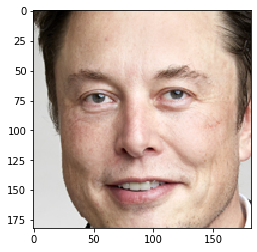

In [8]:
prediction('elon.jpg', model)

16


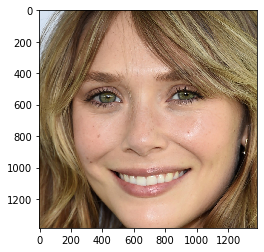

In [10]:
prediction('elizabeth_olsen.jpg', model)

1


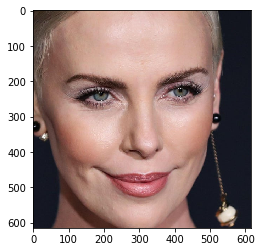

In [11]:
prediction('charlize_theron.jpg', model)

85


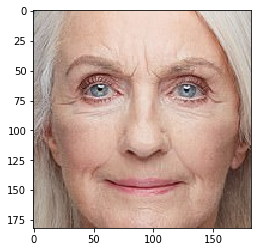

In [12]:
prediction('old_lady.jpg', model)